# Pegado de Imágenes y Panorama

Este proyecto implementa técnicas de alineación y fusión de múltiples imágenes para crear panoramas, utilizando detección de características, matching de descriptores y transformaciones geométricas.



## Objetivos

05:13 (AM): Un sonido de cristal roto interrumpe el silencio en las oficinas del Banco de España. Alguien ha irrumpido en la cámara acorazada y en el camino ha dejado un par de vigilantes muertos. Suena la alarma.06:17 (AM): Se persona la Guardia Civil en la cámara, han desaparecido todas las reservas de Oro. Sólo se ha encontrado un móvil en la escena del crimen con 2 fotografías en el carrete. Los agentes revisan las fotografías y no ven más que un par de imágenes de un escritorio...Como estudiantes de visión por computador... Se analiza podemos ayudar a resolver el misterio. Se analiza podemos descubrir quien es el asesino.



## Configuración del Entorno

Se configuran las bibliotecas necesarias para el procesamiento de imágenes, detección de características, matching de descriptores y transformaciones geométricas.



In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, io, filters, color
from skimage.color import rgb2gray
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, FundamentalMatrixTransform
from skimage.transform import resize
from skimage.transform import warp

from skimage import io, transform
from skimage.feature import ORB, match_descriptors, plot_matches

from ipywidgets import interactive, IntSlider, FloatSlider, VBox, HBox
from IPython.core.display import HTML
from IPython import display
from skimage import exposure, filters


import operator
import math
import warnings
warnings.filterwarnings("ignore")

from utils import dibujar_corners, dibujar_img, dibujar_imgs, dibujar_puntos, mostrar_frames
from utils import blend_rgb
from utils import extraer_ventana, iterador_ventanas

## Carga de Imágenes

Se cargan las imágenes de la escena del crimen desde la carpeta `imgs` para su procesamiento y análisis.



In [9]:
dataset_rgb = io.ImageCollection('imgs/*.jpg')
print("Cargadas {} instancias.".format(len(dataset_rgb)))

Cargadas 2 instancias.


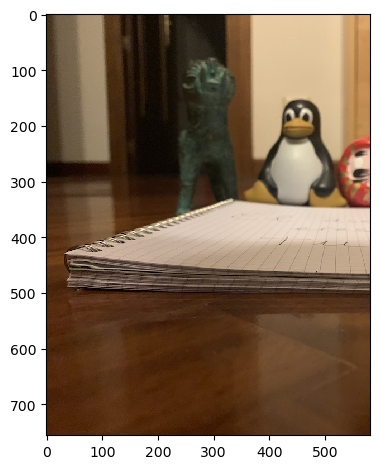

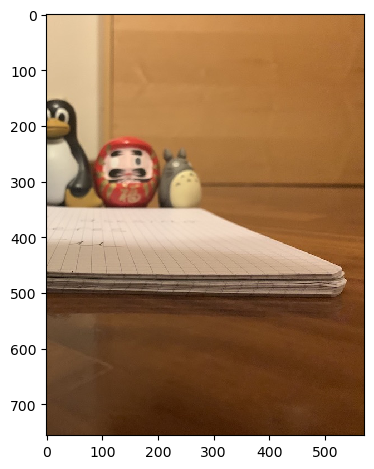

In [10]:
mostrar_frames(dataset_rgb)

## Pegado de las imágenes

generar una única imagen con las que tenemos.



Imágenes cargadas correctamente.


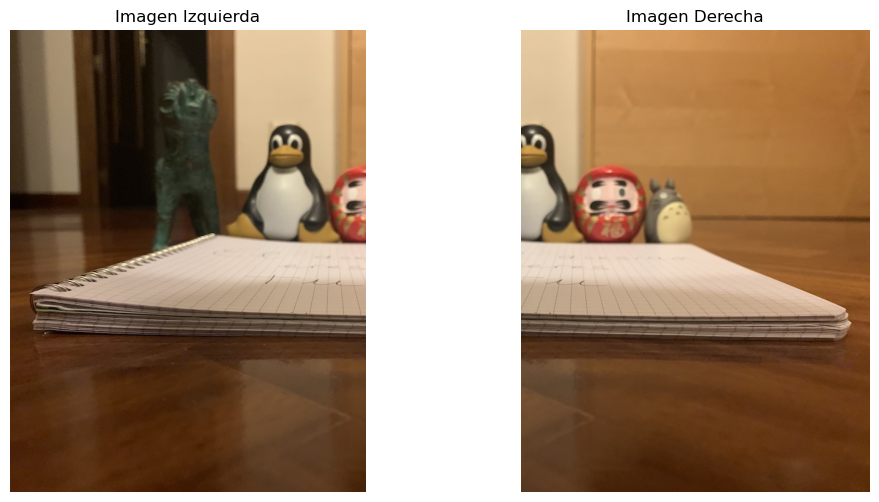

Número de coincidencias iniciales encontradas: 543


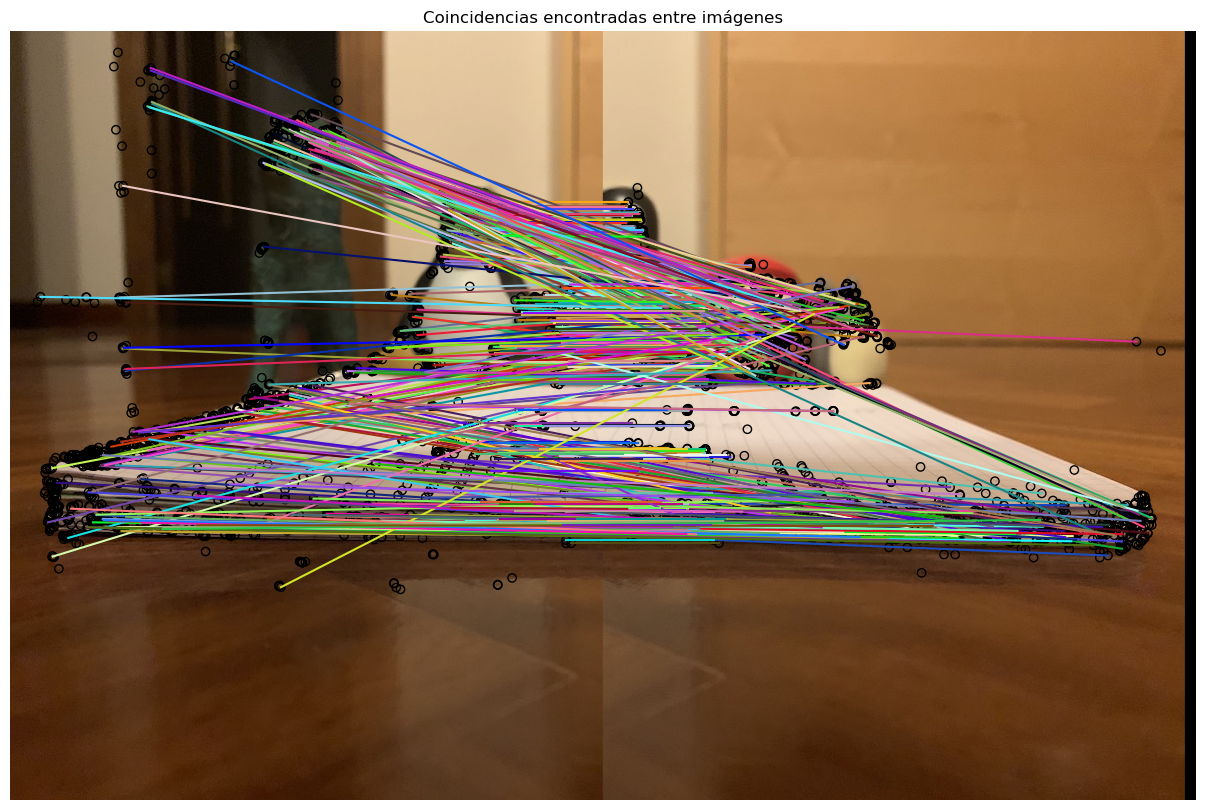

Número de coincidencias válidas (inliers): 296 (54.51%)


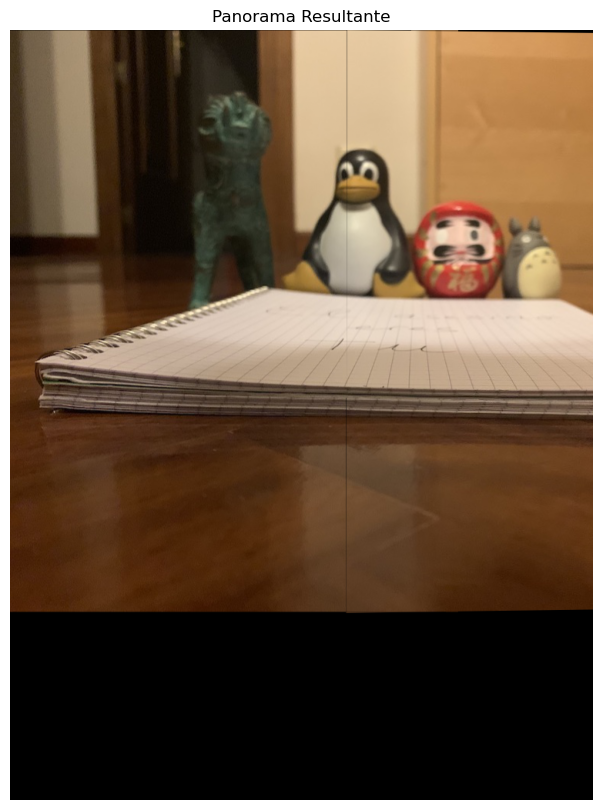

imagen guardada


In [ ]:
try:
    image_collection = io.ImageCollection('imgs/*.jpg')
    image_paths = sorted(image_collection.files)
    
    if len(image_paths) < 2:
        raise IndexError("Se necesitan al menos dos imágenes en la carpeta 'imgs/'.")
        
    img_left_color = io.imread(image_paths[0])
    img_right_color = io.imread(image_paths[1])
    
    # Convertimos a escala de grises para la detección de características
    img_left = color.rgb2gray(img_left_color)
    img_right = color.rgb2gray(img_right_color)

    print("Imágenes cargadas correctamente.")
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_left_color)
    axes[0].set_title("Imagen Izquierda")
    axes[0].axis('off')
    axes[1].imshow(img_right_color)
    axes[1].set_title("Imagen Derecha")
    axes[1].axis('off')
    plt.show()

except (IndexError, FileNotFoundError) as e:
    print(f"Error al cargar las imágenes: {e}")
    raise

# -Detección de características y emparejamiento 
descriptor_extractor = ORB(n_keypoints=2000, fast_threshold=0.05)

# Detectar en la imagen izquierda
descriptor_extractor.detect_and_extract(img_left)
keypoints_left, descriptors_left = descriptor_extractor.keypoints, descriptor_extractor.descriptors

# Detectar en la imagen derecha
descriptor_extractor.detect_and_extract(img_right)
keypoints_right, descriptors_right = descriptor_extractor.keypoints, descriptor_extractor.descriptors

# Emparejar descriptores. cross_check=True 
matches = match_descriptors(descriptors_left, descriptors_right, cross_check=True)
print(f"Número de coincidencias iniciales encontradas: {len(matches)}")

# Visualizar las coincidencias 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plot_matches(ax, img_left_color, img_right_color, keypoints_left, keypoints_right, matches)
ax.axis('off')
ax.set_title("Coincidencias encontradas entre imágenes")
plt.show()

# Estimar la Homografía con RANSAC para robustez 
src = keypoints_right[matches[:, 1]][:, ::-1] 
dst = keypoints_left[matches[:, 0]][:, ::-1] 

# RANSAC encuentra el mejor modelo de transformación (homografía) descartando outliers
model, inliers = ransac(
    (src, dst),
    ProjectiveTransform, min_samples=4,
    residual_threshold=5, max_trials=1000
)

if model is None:
    print("No se pudo estimar la homografía. Asegúrate de que las imágenes se solapan lo suficiente.")
    raise RuntimeError("Fallo en el cálculo de la homografía con RANSAC.")
else:
    inlier_ratio = np.sum(inliers) / len(matches)
    print(f"Número de coincidencias válidas (inliers): {np.sum(inliers)} ({inlier_ratio:.2%})")

# Deformar la imagen derecha para alinearla con la izquierda 
r_left, c_left = img_left.shape
r_right, c_right = img_right.shape

corners_left = np.array([[0, 0], [0, r_left], [c_left, r_left], [c_left, 0]])
corners_right = np.array([[0, 0], [0, r_right], [c_right, r_right], [c_right, 0]])

warped_corners_right = model(corners_right)

all_corners = np.vstack((warped_corners_right, corners_left))
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min).astype(int)
offset = transform.SimilarityTransform(translation=-corner_min)

warped_left = warp(img_left_color, offset.inverse, output_shape=output_shape)

transform_right = model + offset
warped_right = warp(img_right_color, transform_right.inverse, output_shape=output_shape)

# Fusionar las imágenes de forma inteligente 
mask_left = warped_left.sum(axis=2) > 0
mask_right = warped_right.sum(axis=2) > 0
panorama = warped_left.copy()

# Copiamos los píxeles de la imagen derecha donde no hay contenido de la izquierda
non_overlapping_mask = mask_right & ~mask_left
panorama[non_overlapping_mask] = warped_right[non_overlapping_mask]

# En la zona de solapamiento, promediamos los valores para una transición suave
overlapping_mask = mask_left & mask_right
panorama[overlapping_mask] = (warped_left[overlapping_mask] * 0.5 + warped_right[overlapping_mask] * 0.5)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(panorama)
ax.set_title("Panorama Resultante")
ax.axis('off')
plt.show()

io.imsave('fusion_final.jpg', (panorama * 255).astype(np.uint8))
print("imagen guardada")

## Ortorrectificación

Una vez que tengas una sola imagen, Se aplica alguna manera para poder leer lo que pone en la imagen para mejorar los resultados.



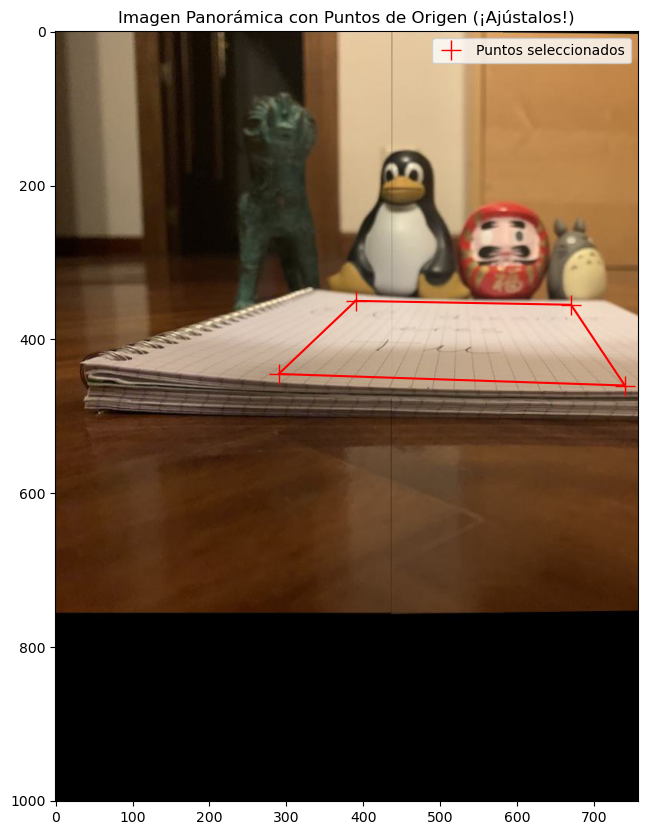

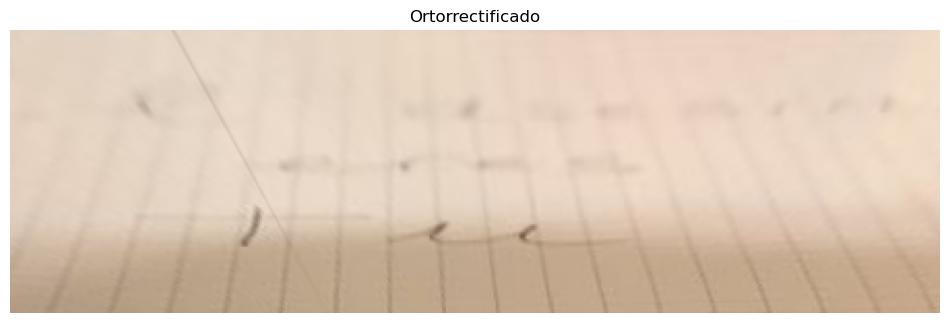

Imagen rectificada guardada


In [12]:
try:
    panorama_color = io.imread('fusion_final.jpg')
except FileNotFoundError:
    print("No se encontró 'fusion_final.jpg'.")
    raise

# Definir los puntos de origen (las 4 esquinas del papel)
puntos_origen = np.array([
    [390, 350],  
    [670, 355], 
    [740, 460], 
    [290, 445]   
])

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(panorama_color)
ax.plot(puntos_origen[:, 0], puntos_origen[:, 1], '+r', markersize=15, label="Puntos seleccionados")
ax.plot(np.append(puntos_origen[:, 0], puntos_origen[0, 0]), 
        np.append(puntos_origen[:, 1], puntos_origen[0, 1]), '-r')
ax.set_title("Imagen Panorámica con Puntos de Origen (¡Ajústalos!)")
ax.legend()
plt.show()


# Definir la imagen de destino y calcular la transformación 
ancho = max(np.linalg.norm(puntos_origen[0] - puntos_origen[1]), 
            np.linalg.norm(puntos_origen[3] - puntos_origen[2]))
alto = max(np.linalg.norm(puntos_origen[0] - puntos_origen[3]), 
           np.linalg.norm(puntos_origen[1] - puntos_origen[2]))

# Mis puntos de destino forman un rectángulo perfecto.
puntos_destino = np.array([
    [0, 0],
    [ancho, 0],
    [ancho, alto],
    [0, alto]
])

# Estimo la transformación proyectiva que mapea los puntos de destino a los de origen.
tform = ProjectiveTransform()
tform.estimate(puntos_destino, puntos_origen)


# Aplico la transformación a la imagen panorámica para ortorrectificarla.
imagen_rectificada = warp(panorama_color, tform, output_shape=(int(alto), int(ancho)))

fig, ax = plt.subplots(figsize=(12, 15))
ax.imshow(imagen_rectificada)
ax.set_title("Ortorrectificado")
ax.axis('off')
plt.show()

# Guardo el resultado para el siguiente paso.
io.imsave('imagen_rectificada.jpg', (imagen_rectificada * 255).astype(np.uint8))
print("Imagen rectificada guardada")

## Mejora de imagen 


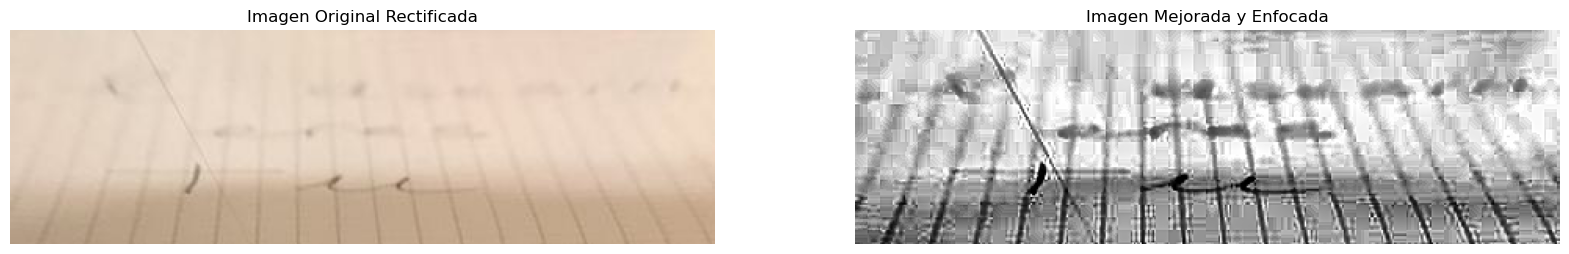

Imagen final guardada


In [15]:
try:
    imagen_rectificada = io.imread('imagen_rectificada.jpg')
except FileNotFoundError:
    print("No se encontró 'imagen_rectificada.jpg'")
    raise

# Convierto la imagen a escala de grises para el procesamiento.
imagen_gris = color.rgb2gray(imagen_rectificada)

# Aplico CLAHE para mejorar el contraste de forma adaptativa.
contraste_mejorado = exposure.equalize_adapthist(imagen_gris, clip_limit=0.03)

# Aplico un filtro de enfoque (unsharp mask) para hacer el texto más nítido.
imagen_mejorada = filters.unsharp_mask(contraste_mejorado, radius=1, amount=1.5)

# Muestro una comparación del antes y el después.
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(imagen_rectificada, cmap='gray')
axes[0].set_title("Imagen Original Rectificada")
axes[0].axis('off')

axes[1].imshow(imagen_mejorada, cmap='gray')
axes[1].set_title("Imagen Mejorada y Enfocada")
axes[1].axis('off')

plt.show()

# Guardo la imagen final, lista para ser presentada como prueba.
io.imsave('imagen_mejorada.jpg', (imagen_mejorada * 255).astype(np.uint8))
print("Imagen final guardada")

## Se analiza Quién es el asesino.



In [ ]:
# YO CREO LEER "EL ASESINO ERES TU" 
